# This is the work notebook of the final project.
# The aim of this project is to create a route planner service for pedestrians with disabilities or difficulties with walking. 
# The inspiration for this work came from the motivational quiet path route service we were shown on one class and from a collegue who is working with accessibility topics.
# I received some spatial accessibility data from the city of Helsinki via a collegue. The city officials hoped some sort of tool to see 
# which routes where accessible to which usergroups. I didn't have time to fully take in count the different user groups.

In [2]:
#Imports
#import gdal
import pandas as pd
import geopandas as gpd
from geopandas.tools import geocode
import requests
import geojson
import matplotlib
%matplotlib inline
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
import shapely.speedups
import folium
import contextily as ctx
from pyproj import CRS
import osmnx as ox
import networkx as nx
import contextily as ctx
import mplleaflet

ImportError: libkea.so.1.4.7: cannot open shared object file: No such file or directory

In [2]:
# This data consists of Special accessibility level areas such as squares or pedestrian streets.
etasonAlueet = gpd.read_file("Lahtotiedot/Erikoistason_alueet_shp-export/HKRPTY_esteettomyys_erikois_alue_areas.shp")

In [3]:
# Let's see what kind of data it is.
print("Aineistossa on ", len(etasonAlueet), " riviä")
print(etasonAlueet.iloc[0:1]['geometry'])

Aineistossa on  72  riviä
0    POLYGON ((25506632.826 6677060.280, 25506711.7...
Name: geometry, dtype: geometry


In [4]:
# This is the special accessibility level pedestrian and wheelchair routes.
etasonReitit = gpd.read_file("Lahtotiedot/Erikoistason_reitti_toteutunut/HKRPTY_esteettomyys_TOT_erikois_reitti_lines.shp")

In [5]:
print("Aineistossa on ", len(etasonReitit), " riviä")
etasonReitit.head()
etasonReitit.crs

Aineistossa on  868  riviä


{'init': 'epsg:3879'}

In [6]:
# This data consists of the voice signageg traffic lights for blind people.
aaniopasteet = gpd.read_file("Lahtotiedot/HELSINKI1_OjalaKi_20191219_160434 (1)/HKRPTY_esteettomyys_TOT_aaniopas_suojat.tab")

In [7]:
print("Aineistossa on ", len(aaniopasteet), " riviä")
aaniopasteet.head()

Aineistossa on  351  riviä


,gml_id,tunniste,luokka1,luokka2,lisatieto1,lisatieto2,toteutunut_esteettomyys,geometry
0,HKRPTY_esteettomyys_TOT_aaniopas_suojat.1329,0,Suojatie,Perustaso,Saareke,Ääniohjaus,,"LINESTRING (25493826.180 6680518.470, 25493798..."
1,HKRPTY_esteettomyys_TOT_aaniopas_suojat.1595,0,Suojatie,Perustaso,,Ääniohjaus,,"LINESTRING (25495099.200 6675162.230, 25495114..."
2,HKRPTY_esteettomyys_TOT_aaniopas_suojat.1496,0,Suojatie,Perustaso,Saareke,Ääniohjaus,,"LINESTRING (25493562.120 6677184.470, 25493548..."
3,HKRPTY_esteettomyys_TOT_aaniopas_suojat.1636,0,Suojatie,Perustaso,Saareke,Ääniohjaus,,"LINESTRING (25491658.650 6679548.940, 25491644..."
4,HKRPTY_esteettomyys_TOT_aaniopas_suojat.4485,0,Suojatie,Perustaso,,Ääniohjaus,,"LINESTRING (25496965.080 6677438.790, 25496960..."


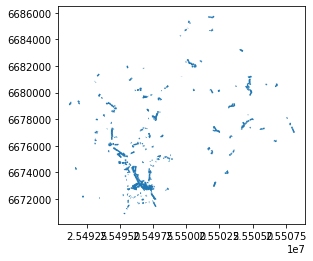

In [8]:
# Let's see where the special level routes are.
etasonReitit.plot()

In [16]:
# For folium package we need to change the crs into WGS84
print(etasonReitit.crs)
etasonReititWGS84 = etasonReitit.to_crs(epsg=4326)
aaniopasteetWGS84 = aaniopasteet.to_crs(epsg=4326)
etasonAlueetWGS84 = etasonAlueet.to_crs(epsg=4326)

etasonReititWGS84.tail()

{'init': 'epsg:3879'}


/home/vipy/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/vipy/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/vipy/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


,gml_id,tunniste,luokka1,luokka2,lisatieto1,lisatieto2,toteutunut,geometry
863,HKRPTY_esteettomyys_TOT_erikois_reitti.16820,None,Suojatie,Erikoistaso,Saareke,Ääniohjaus,Kyllä,"LINESTRING (25.07630 60.20932, 25.07634 60.20920)"
864,HKRPTY_esteettomyys_TOT_erikois_reitti.16828,None,Reitti,Erikoistaso,None,None,Kyllä,"LINESTRING (25.05878 60.19061, 25.05942 60.190..."
865,HKRPTY_esteettomyys_TOT_erikois_reitti.15858,None,Reitti,Erikoistaso,None,None,Kyllä,"LINESTRING (24.95509 60.16783, 24.95571 60.167..."
866,HKRPTY_esteettomyys_TOT_erikois_reitti.15862,None,Reitti,Erikoistaso,None,None,Kyllä,"LINESTRING (24.95592 60.16921, 24.95668 60.169..."
867,HKRPTY_esteettomyys_TOT_erikois_reitti.16195,None,Reitti,Erikoistaso,None,None,Kyllä,"LINESTRING (24.96672 60.20276, 24.96660 60.202..."


In [17]:
# There are some columns that mean the same thing but are written in a different way in different datasets. 
# Let's unify them, so we can unite the data later on.
etasonAlueetWGS84 = etasonAlueetWGS84.rename(
    columns={'TUNNISTE' : 'tunniste', 'LUOKKA1' : 'luokka1',
            'LUOKKA2' : 'luokka2', 'LISATIETO1' : 'lisatieto1',
            'LISATIETO2' : 'lisatieto2'})

In [18]:
etasonAlueetWGS84.head()

,gml_id,tunniste,luokka1,luokka2,lisatieto1,lisatieto2,AIKA,TEKIJA,geometry
0,None,38.0,Asema,Erikoistaso,Metroasema,Rastilan metroasema,2016-10-05T14:35:44,AHellén,"POLYGON ((25.11961 60.20627, 25.12104 60.20603..."
1,None,54.0,Asema,Erikoistaso,Metroasema,Siilitien metroasema,2016-10-05T14:35:44,AHellén,"POLYGON ((25.04348 60.20503, 25.04454 60.20587..."
2,None,51.0,Keskus,Erikoistaso,Vuosaaren keskus,None,2016-10-05T14:35:44,AHellén,"POLYGON ((25.14372 60.20811, 25.14446 60.20827..."
3,None,53.0,Asema,Erikoistaso,Metroasema,Vuosaaren metroasema,2016-10-05T14:35:44,AHellén,"POLYGON ((25.14054 60.20736, 25.14398 60.20760..."
4,None,39.0,None,Erikoistaso,None,None,2016-10-05T14:35:44,AHellén,"POLYGON ((25.07641 60.20848, 25.07641 60.20848..."


In [19]:
# Next we fetch a Graph from Open Street Map so we can make shortest path analysis.
# I checked some boundaries for the graph from Open Street Map webmap and set them as a bounding box for the graph.

polyBorder = Polygon([(24.850000, 60.200000), (24.990000, 60.200000),
                     (24.990000, 60.150000), (24.850000, 60.150000)])
graph = ox.graph_from_bbox(north=60.183715, south=60.160687, east=24.965640, 
                           west=24.917896, network_type='walk')

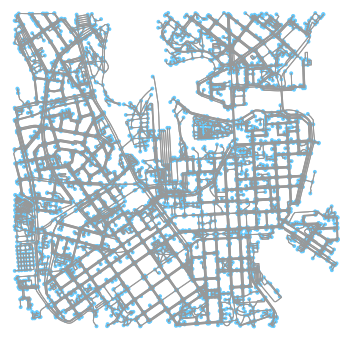

In [20]:
# Let's see what it looks like.
fig, ax = ox.plot_graph(graph)

In [22]:
#graphP = ox.project_graph(graph)
aaniopasteetWGS84.tail()

,gml_id,tunniste,luokka1,luokka2,lisatieto1,lisatieto2,toteutunut_esteettomyys,geometry
346,HKRPTY_esteettomyys_TOT_aaniopas_suojat.16190,0,Suojatie,Perustaso,,Ääniohjaus,,"LINESTRING (24.96487 60.21506, 24.96496 60.21498)"
347,HKRPTY_esteettomyys_TOT_aaniopas_suojat.16191,0,Suojatie,Perustaso,,Ääniohjaus,,"LINESTRING (24.96475 60.21516, 24.96465 60.21524)"
348,HKRPTY_esteettomyys_TOT_aaniopas_suojat.16192,0,Suojatie,Perustaso,,Ääniohjaus,,"LINESTRING (24.97006 60.21269, 24.97030 60.21262)"
349,HKRPTY_esteettomyys_TOT_aaniopas_suojat.16193,0,Suojatie,Perustaso,,Ääniohjaus,,"LINESTRING (24.97042 60.21260, 24.97058 60.21256)"
350,HKRPTY_esteettomyys_TOT_aaniopas_suojat.16194,0,Suojatie,Perustaso,Saareke,Ääniohjaus,,"LINESTRING (24.96844 60.21076, 24.96897 60.21062)"


In [23]:
# Then I continued unifying the data.
aaniopasteetWGS84 = aaniopasteetWGS84.rename(columns=({'toteutunut_esteettomyys' : 'toteutunut'}))
aaniopasteetWGS84.tail()

,gml_id,tunniste,luokka1,luokka2,lisatieto1,lisatieto2,toteutunut,geometry
346,HKRPTY_esteettomyys_TOT_aaniopas_suojat.16190,0,Suojatie,Perustaso,,Ääniohjaus,,"LINESTRING (24.96487 60.21506, 24.96496 60.21498)"
347,HKRPTY_esteettomyys_TOT_aaniopas_suojat.16191,0,Suojatie,Perustaso,,Ääniohjaus,,"LINESTRING (24.96475 60.21516, 24.96465 60.21524)"
348,HKRPTY_esteettomyys_TOT_aaniopas_suojat.16192,0,Suojatie,Perustaso,,Ääniohjaus,,"LINESTRING (24.97006 60.21269, 24.97030 60.21262)"
349,HKRPTY_esteettomyys_TOT_aaniopas_suojat.16193,0,Suojatie,Perustaso,,Ääniohjaus,,"LINESTRING (24.97042 60.21260, 24.97058 60.21256)"
350,HKRPTY_esteettomyys_TOT_aaniopas_suojat.16194,0,Suojatie,Perustaso,Saareke,Ääniohjaus,,"LINESTRING (24.96844 60.21076, 24.96897 60.21062)"


In [24]:
# Next I extracted the nodes and edges as geo dataframes.
nodes, edges = ox.graph_to_gdfs(graph, nodes=True, edges=True)

In [25]:
edges.crs

'+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

In [26]:
print(len(edges))
edges.head()

23214


,u,v,key,osmid,highway,oneway,length,geometry,tunnel,name,service,lanes,maxspeed,bridge,access,width,ref,est_width,junction
0,3196174340,913578188,0,8035247,footway,False,6.557,"LINESTRING (24.92952 60.17323, 24.92941 60.17321)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3196174340,308783762,0,28788947,footway,False,2.043,"LINESTRING (24.92952 60.17323, 24.92951 60.17325)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3196174340,296556313,0,28788947,footway,False,99.141,"LINESTRING (24.92952 60.17323, 24.93032 60.172...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3196174341,3196174350,0,"[313613081, 313613084]",service,False,16.615,"LINESTRING (24.92993 60.17325, 24.92975 60.173...",building_passage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,296043616,295064653,0,317591141,footway,False,63.276,"LINESTRING (24.93189 60.17067, 24.93254 60.17021)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


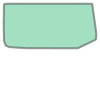

In [27]:
convexHull = edges.unary_union.convex_hull
convexHull

In [28]:
from folium.features import FeatureGroup, GeoJson, TopoJson, Marker

nodesGeoJson = GeoJson(nodes, name="places")
etasonReititGeoJson = GeoJson(etasonReititWGS84, name="etasonReitit")
etasonAlueetGeoJson = GeoJson(etasonAlueetWGS84, name="etasonAlueet")
aaniopasteetGeoJson = GeoJson(aaniopasteetWGS84, name="aaniopasteet")


/home/vipy/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/vipy/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [175]:
etasonReititWGS84.to_file("Lahtotiedot/etasonreititkartalle.geojson", driver='GeoJSON')

In [176]:
etasonAlueetWGS84.to_file("Lahtotiedot/etasonalueetkartalle.geojson", driver='GeoJSON')

aaniopasteetWGS84.to_file("Lahtotiedot/aaniopasteetkartalle.geojson", driver='GeoJSON')


In [177]:
edgesGeoJson = GeoJson(edges, name="edges")

In [29]:
etasonReititWGS84 = etasonReititWGS84.loc[(etasonReititWGS84['geometry'].within(convexHull))]
etasonAlueetWGS84 = etasonAlueetWGS84.loc[(etasonAlueetWGS84['geometry'].within(convexHull))]
aaniopasteetWGS84 = aaniopasteetWGS84.loc[(aaniopasteetWGS84['geometry'].within(convexHull))]

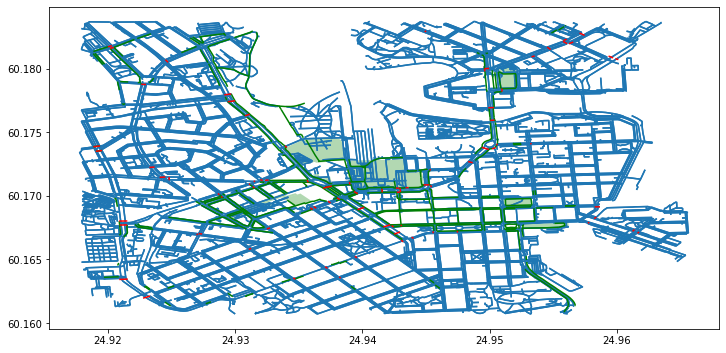

In [30]:
fig, ax = plt.subplots(figsize=(12,12))
edges.plot(ax=ax)
etasonReititWGS84.plot(ax=ax, color='green')
etasonAlueetWGS84.plot(ax=ax, color='green', alpha = 0.3)
aaniopasteetWGS84.plot(ax=ax, color='red')

In [24]:
esteettomyysMap = "Helsingin_keskustan_estettömyys.png"
fig.savefig(esteettomyysMap, dpi=300)

In [31]:
center = convexHull.centroid
center.x


24.941086259162248

In [3]:
from shapely.geometry import mapping
from folium.plugins import MarkerCluster, Search, PolyLineTextPath
from folium.utilities import parse_options
from folium import plugins
import cgi
from osgeo import gdal
# Now we can start visualizing


ModuleNotFoundError: No module named 'folium'

In [33]:
# I wanted to make buffer areas for the special level routes and voice sinage so that I can use them for the route analysis.
# So I changed the crs to ETRS TM-35 so I can use metres as buffer length.
etasonReititWGS84 = etasonReititWGS84.to_crs(epsg=3879)
aaniopasteetWGS84 = aaniopasteetWGS84.to_crs(epsg=3879)
etasonAlueetWGS84 = etasonAlueetWGS84.to_crs(epsg=3879)
etasonReititWGS84.head()

/home/vipy/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/vipy/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/vipy/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


,gml_id,tunniste,luokka1,luokka2,lisatieto1,lisatieto2,toteutunut,geometry
1,HKRPTY_esteettomyys_TOT_erikois_reitti.2558,None,Reitti,Erikoistaso,Ei talvikunnossapitoa,None,Kyllä,"LINESTRING (25496827.491 6672981.527, 25496957..."
39,HKRPTY_esteettomyys_TOT_erikois_reitti.10078,None,Reitti,Erikoistaso,None,None,Kyllä,"LINESTRING (25495585.415 6674315.651, 25495622..."
40,HKRPTY_esteettomyys_TOT_erikois_reitti.10081,None,Reitti,Erikoistaso,None,None,Kyllä,"LINESTRING (25496131.809 6673039.414, 25496140..."
41,HKRPTY_esteettomyys_TOT_erikois_reitti.10082,None,Reitti,Erikoistaso,None,None,Kyllä,"LINESTRING (25496145.085 6673047.634, 25496145..."
42,HKRPTY_esteettomyys_TOT_erikois_reitti.10091,None,Reitti,Erikoistaso,None,None,Kyllä,"LINESTRING (25496839.152 6672748.389, 25496804..."


In [34]:
etasonReititWGS84.crs


{'init': 'epsg:3879', 'no_defs': True}

In [35]:
# Then I buffered the routes with 10 metre buffer in case the OSM routes are offset from the data from city of Helsinki. 
# I figured that 10 metres should be enough because it is not that far to walk even for people with dissabilities and sometimes 
# OSM seems locate the "walk"-graph on drive ways which can be quite far from the side walk.
etasonReititWGS84['bufferareas'] = etasonReititWGS84.geometry.buffer(10)

In [36]:
etasonReititWGS84.head()

,gml_id,tunniste,luokka1,luokka2,lisatieto1,lisatieto2,toteutunut,geometry,bufferareas
1,HKRPTY_esteettomyys_TOT_erikois_reitti.2558,None,Reitti,Erikoistaso,Ei talvikunnossapitoa,None,Kyllä,"LINESTRING (25496827.491 6672981.527, 25496957...","POLYGON ((25496957.193 6672995.204, 25496958.1..."
39,HKRPTY_esteettomyys_TOT_erikois_reitti.10078,None,Reitti,Erikoistaso,None,None,Kyllä,"LINESTRING (25495585.415 6674315.651, 25495622...","POLYGON ((25495631.255 6674247.866, 25495634.1..."
40,HKRPTY_esteettomyys_TOT_erikois_reitti.10081,None,Reitti,Erikoistaso,None,None,Kyllä,"LINESTRING (25496131.809 6673039.414, 25496140...","POLYGON ((25496149.128 6673028.314, 25496171.7..."
41,HKRPTY_esteettomyys_TOT_erikois_reitti.10082,None,Reitti,Erikoistaso,None,None,Kyllä,"LINESTRING (25496145.085 6673047.634, 25496145...","POLYGON ((25496135.729 6673052.399, 25496135.9..."
42,HKRPTY_esteettomyys_TOT_erikois_reitti.10091,None,Reitti,Erikoistaso,None,None,Kyllä,"LINESTRING (25496839.152 6672748.389, 25496804...","POLYGON ((25496811.708 6672732.439, 25496811.6..."


In [37]:
# Now let's change the buffer column as the 'geometry' and rename it.

etasonReititWGS84 = etasonReititWGS84.rename(columns={'geometry' : 'linestring', 'bufferareas' : 'geometry'})



In [38]:
etasonReititWGS84 = etasonReititWGS84.set_geometry('geometry')

In [39]:
# The I joined the buffers as one multipolygon. That enables to make fast and easy analysis on whether a line string is 
# on an special accessible route.
reittiyhdiste = etasonReititWGS84.unary_union

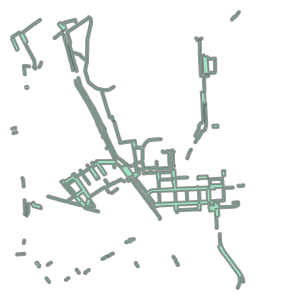

In [40]:
reittiyhdiste

In [41]:
# Then let's do the same with the voice signage.
aaniopasteetWGS84['bufferareas'] = aaniopasteetWGS84['geometry'].buffer(10)
aaniopasteetWGS84 = aaniopasteetWGS84.rename(columns={'geometry' : 'linestring', 'bufferareas' : 'geometry'})



In [42]:
aaniopasteetWGS84 = aaniopasteetWGS84.set_geometry('geometry')

In [43]:
aaniopasteetyhdiste = aaniopasteetWGS84.unary_union



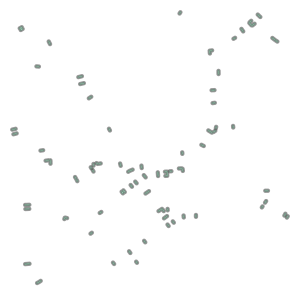

In [44]:
aaniopasteetyhdiste

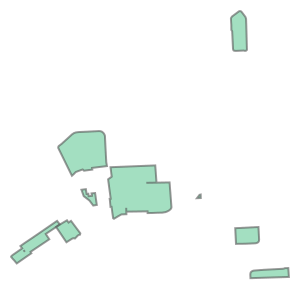

In [45]:
# ... And join the special accessible squares as well.
alueyhdiste = etasonAlueetWGS84.unary_union
alueyhdiste

In [46]:
aaniopasteetWGS84.tail()

,gml_id,tunniste,luokka1,luokka2,lisatieto1,lisatieto2,toteutunut,linestring,geometry
308,HKRPTY_esteettomyys_TOT_aaniopas_suojat.16469,0,Suojatie,Erikoistaso,,Ääniohjaus,,"LINESTRING (25497150.360 6673303.990, 25497130...","POLYGON ((25497125.721 6673305.490, 25497124.8..."
328,HKRPTY_esteettomyys_TOT_aaniopas_suojat.15835,0,Suojatie,Perustaso,,Ääniohjaus,,"LINESTRING (25497876.180 6672696.900, 25497868...","POLYGON ((25497877.281 6672680.077, 25497876.7..."
329,HKRPTY_esteettomyys_TOT_aaniopas_suojat.15836,0,Suojatie,Perustaso,,Ääniohjaus,,"LINESTRING (25497658.470 6672781.830, 25497652...","POLYGON ((25497660.820 6672767.630, 25497660.2..."
332,HKRPTY_esteettomyys_TOT_aaniopas_suojat.15847,0,Suojatie,Perustaso,,Ääniohjaus,,"LINESTRING (25497689.400 6672827.970, 25497680...","POLYGON ((25497688.501 6672808.804, 25497687.9..."
333,HKRPTY_esteettomyys_TOT_aaniopas_suojat.15848,0,Suojatie,Perustaso,,Ääniohjaus,,"LINESTRING (25497855.960 6672718.690, 25497847...","POLYGON ((25497856.241 6672697.908, 25497855.7..."


In [196]:
# I wanted to know more about what kind of data some of the columns had on the OSM edges, but I didn't fully understand what they were. 
# Propably they aren't that important.
edges.loc[edges['access'].notnull()]

,u,v,key,osmid,highway,oneway,length,geometry,tunnel,name,service,lanes,maxspeed,bridge,access,width,ref,est_width,junction
366,3452027200,150501018,0,26134554,service,False,34.510,"LINESTRING (24.91883 60.16931, 24.91830 60.16947)",NaN,NaN,NaN,NaN,NaN,NaN,destination,NaN,NaN,NaN,NaN
367,3452027200,3452026292,0,26134554,service,False,25.290,"LINESTRING (24.91883 60.16931, 24.91923 60.16919)",NaN,NaN,NaN,NaN,NaN,NaN,destination,NaN,NaN,NaN,NaN
412,5964136804,25473362,0,"[631582724, 631582725, 45602486]","[footway, service]",False,451.304,"LINESTRING (24.93828 60.17904, 24.93835 60.179...",NaN,NaN,driveway,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN
816,3673096875,297282292,0,"[29004976, 59148119]",footway,False,53.085,"LINESTRING (24.93792 60.17245, 24.93730 60.172...",yes,NaN,NaN,NaN,NaN,NaN,permissive,NaN,NaN,NaN,NaN
817,3673096875,733251942,0,"[29004976, 59148125]",footway,False,51.549,"LINESTRING (24.93792 60.17245, 24.93846 60.172...",yes,NaN,NaN,NaN,NaN,NaN,permissive,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22749,311049857,1005473403,0,618189328,footway,False,2.470,"LINESTRING (24.94803 60.16282, 24.94803 60.16279)",NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN
22750,311049857,6497762618,0,"[692229770, 54819039]",footway,False,90.223,"LINESTRING (24.94803 60.16282, 24.94772 60.162...",NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN
22751,311049857,299979865,0,618189328,footway,False,7.721,"LINESTRING (24.94803 60.16282, 24.94802 60.162...",NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN
22848,1371750101,295055252,0,8061216,service,False,9.394,"LINESTRING (24.93613 60.16901, 24.93626 60.16906)",NaN,NaN,NaN,2,NaN,NaN,no,NaN,NaN,NaN,NaN


In [197]:
#etasonReititWGS84 = etasonReititWGS84.drop(['linestring'], axis=1)

In [47]:
# Then I changed the dataframes back to WGS84.
etasonReititWGS84 = etasonReitit.to_crs(epsg=4326)
aaniopasteetWGS84 = aaniopasteet.to_crs(epsg=4326)
etasonAlueetWGS84 = etasonAlueet.to_crs(epsg=4326)

etasonReititWGS84.tail()


/home/vipy/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/vipy/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/vipy/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


,gml_id,tunniste,luokka1,luokka2,lisatieto1,lisatieto2,toteutunut,geometry
863,HKRPTY_esteettomyys_TOT_erikois_reitti.16820,None,Suojatie,Erikoistaso,Saareke,Ääniohjaus,Kyllä,"LINESTRING (25.07630 60.20932, 25.07634 60.20920)"
864,HKRPTY_esteettomyys_TOT_erikois_reitti.16828,None,Reitti,Erikoistaso,None,None,Kyllä,"LINESTRING (25.05878 60.19061, 25.05942 60.190..."
865,HKRPTY_esteettomyys_TOT_erikois_reitti.15858,None,Reitti,Erikoistaso,None,None,Kyllä,"LINESTRING (24.95509 60.16783, 24.95571 60.167..."
866,HKRPTY_esteettomyys_TOT_erikois_reitti.15862,None,Reitti,Erikoistaso,None,None,Kyllä,"LINESTRING (24.95592 60.16921, 24.95668 60.169..."
867,HKRPTY_esteettomyys_TOT_erikois_reitti.16195,None,Reitti,Erikoistaso,None,None,Kyllä,"LINESTRING (24.96672 60.20276, 24.96660 60.202..."


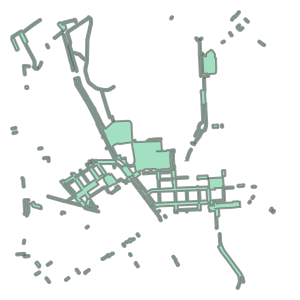

In [48]:
# I made finally a union of all of the unobstructed routes, traffic lights and squares as a one big multipolygon.
geoms = [aaniopasteetyhdiste, alueyhdiste, reittiyhdiste]
etasonKokoelma = shapely.ops.cascaded_union(geoms)
etasonKokoelma

In [49]:
type(etasonKokoelma)

shapely.geometry.multipolygon.MultiPolygon

In [50]:
# Which I still wanted as a geo dataframe since the previous geo dataframes lost the buffer areas as geometry when I changes CRS 
# for some reason.
# I couldn't figure out what was the problem with that, but creating a new geo dataframe solved it.
esteeton = gpd.GeoDataFrame()

In [51]:
esteeton['geometry']= etasonKokoelma

In [52]:
esteeton.crs = CRS.from_epsg(3879)

In [53]:
esteeton = esteeton.to_crs(epsg=4326)

/home/vipy/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [104]:
esteeton.to_file("Lahtotiedot/esteetonalue.shp")

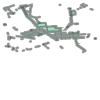

In [55]:
esteetonAluekartalle = esteeton.unary_union
esteetonAluekartalle

In [56]:
x, y = esteetonAluekartalle[0].exterior.coords.xy
print(x[0], y[0])

24.943351033327634 60.166444899933985


In [131]:
import networkx as nx


In [55]:
import fiona; fiona.supported_drivers

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'raw',
 'DXF': 'raw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRI Shapefile': 'raw',
 'GeoJSON': 'rw',
 'GPKG': 'rw',
 'GML': 'raw',
 'GPX': 'raw',
 'GPSTrackMaker': 'raw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r'}

In [60]:
edges.crs = CRS.from_epsg(4326)


/home/vipy/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [205]:
edges = edges.to_crs(epsg=4326)

/home/vipy/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [148]:
edges.head(5)


,u,v,key,osmid,highway,oneway,length,geometry,weighted_length,esteeton
0,3196174340,913578188,0,8035247,footway,False,6.557,"LINESTRING (24.92952 60.17324, 24.92941 60.17321)",6.557,False
1,3196174340,308783762,0,28788947,footway,False,2.043,"LINESTRING (24.92952 60.17324, 24.92951 60.17325)",2.043,False
2,3196174340,296556313,0,28788947,footway,False,99.141,"LINESTRING (24.92952 60.17324, 24.93032 60.172...",99.141,False
3,3196174341,3196174350,0,313613081,service,False,16.615,"LINESTRING (24.92993 60.17325, 24.92975 60.173...",16.615,False
4,296043616,295064653,0,317591141,footway,False,63.276,"LINESTRING (24.93189 60.17067, 24.93254 60.17021)",21.092,True


In [ ]:
#Let's see, what the unobstructed routes look like on an interactive map.
m = folium.Map(location= [center.y, center.x], zoom_start=14, min_zoom = 14, 
               max_zoom= 20, control_scale=True, tiles="CartoDB Positron")
#edgesGeoJson.add_to(m)
etasonReititGeoJson.add_to(m)
etasonAlueetGeoJson.add_to(m)
aaniopasteetGeoJson.add_to(m)


In [ ]:
m

In [213]:
nodes.crs
edges.crs

{'init': 'epsg:4326', 'no_defs': True}

In [206]:
# Here I tested some random addresses that one can test the app with
# One can change these addresses as long as they are in Helsinki center.
origAddress = "Rautatientori, Helsinki"
destAddress = "Punavuorenkatu 19, Helsinki"

# Geocode addresses using Nominatim. Remember to provide a custom "application name"
# in the user_agent parameter!

orig = geocode(origAddress, provider='nominatim', user_agent='autogis_xx', 
               timeout=4)
dest = geocode(destAddress, provider='nominatim', user_agent='autogis_xx', 
               timeout=4)

In [ ]:
esteetonreititGJ = GeoJson(esteeton, name="esteeton_reitti_alue")

In [221]:
# So here is the app to find path. 
#It shows on the maps which parts are unobstructed and which are not




orig_yx = (orig['geometry'].at[0].y, orig['geometry'].at[0].x)
dest_yx = (dest['geometry'].at[0].y, dest['geometry'].at[0].x)


oNearest = ox.get_nearest_node(graph, orig_yx, method='euclidean')
dNearest = ox.get_nearest_node(graph, dest_yx, method='euclidean')

origo = nodes.loc[oNearest]
destination = nodes.loc[dNearest]

odNodes = gpd.GeoDataFrame([origo, destination], geometry='geometry', crs=nodes.crs)


route = nx.shortest_path(G=graph, source=oNearest, target=dNearest, weight='length')


path = []


for i in range(len(route)-1):
    point = nodes.loc[route[i]].geometry
    path.append([point.y, point.x])
    

                                 
    
m = folium.Map(location= [path[0][0], path[0][1]], zoom_start=17, min_zoom = 13, max_zoom= 20, control_scale=True, tiles="CartoDB Positron")

etasonReititGeoJson.add_to(m)
etasonAlueetGeoJson.add_to(m)
aaniopasteetGeoJson.add_to(m)

startMarker = folium.Marker(location= [path[0][0], path[0][1]], popup='Lähtöosoite: ' + origAddress).add_to(m)

for i in range(len(route)-1):
    pathP = []

    point1 = Point(nodes.loc[route[i]].geometry.x, nodes.loc[route[i]].geometry.y)
    
    point2 = Point(nodes.loc[route[i+1]].geometry.x, nodes.loc[route[i+1]].geometry.y)
    
    pathP.append([nodes.loc[route[i]].geometry.y, nodes.loc[route[i]].geometry.x])
    pathP.append([nodes.loc[route[i+1]].geometry.y, nodes.loc[route[i+1]].geometry.x])
    #print(pathP)
    lineString = LineString([point1, point2])
    if point1.within(esteetonAluekartalle) and point2.within(esteetonAluekartalle):
        attr = {'fill': 'black', 'font-weight': 'bold', 'font-size': '16'}
        pline = folium.PolyLine(pathP, weight=8, color='green', opacity=0.6).add_to(m)

    else:
        attr = {'fill': 'black', 'font-weight': 'bold', 'font-size': '16'}
        pline = folium.PolyLine(pathP, weight=8, color='red', opacity=0.6).add_to(m)
        
endMarker = folium.Marker(location= [path[len(path)-1][0], path[len(path)-1][1]], popup='Määränpää: ' + destAddress).add_to(m)


m

In [179]:
m.save("valitulostus1.html")